## <center><ins>Trabajo Práctico 1: Reservas de hotel</ins></center>
#### <center>*Checkpoint 3: Ensambles - Random Forest*</center>
##### <center>75.06 / 95.58 Organización de Datos - FIUBA</center>
##### <center>Ing. Rodríguez - 1°C 2023</center>
---
#### <center>**Grupo 31 - "Datazo":**</center>
<center> Michael Mena - 102685</center>
<center>Pablo Brocca - 104256</center>
<center>Diego Kisinovsky - 106203</center>

---
---

## Carga de datos y librerías

##### Imports:

In [1]:
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import dtreeviz.trees as dtreeviz
import pydotplus
from IPython.display import Image

# Modelos y métricas
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from six import StringIO

# Preprocesamiento
from sklearn.preprocessing import MinMaxScaler

# Manejo de modelos
from pickle import dump
from pickle import load

# Configuración de warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)




##### Lectura del dataset preprocesado:

In [2]:
hotel_train = pd.read_csv('./dataset/hotels_train_preprocesado.csv')

---

## Armado y entrenamiento del modelo

##### Preparación de features:

In [3]:
features = hotel_train.drop(['is_canceled'],axis=1).columns
          
target = 'is_canceled'

features.tolist()

['lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_day_of_month',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'stays_in_nights',
 'total_of_guests',
 'room_type_unchanged',
 'country_encoded',
 'customer_type_Group',
 'customer_type_Transient',
 'customer_type_Transient-Party',
 'deposit_type_Non Refund',
 'deposit_type_Refundable',
 'hotel_Resort Hotel',
 'distribution_channel_Direct',
 'distribution_channel_GDS',
 'distribution_channel_TA/TO',
 'distribution_channel_Undefined',
 'market_segment_Complementary',
 'market_segment_Corporate',
 'market_segment_Direct',
 'market_segment_Groups',
 'market_segment_Offline TA/TO',
 'market_segment_Online TA',
 'market_segment_Undefined',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'meal_Undefined']

##### Train-Test Split:

In [4]:
# Separamos un 20% de los datos para test
x_train, x_test, y_train, y_test = train_test_split(hotel_train[features].values, 
                                                    hotel_train[target].values, 
                                                    test_size=0.2,    
                                                    random_state=42,  
                                                    stratify=hotel_train[target].values) 

# Verificamos cantidad de datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

# Verificamos como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 48682
# Datos Prueba: 12171
% Positivos Entrenamiento: 50.433
% Positivos Prueba: 50.431


##### Random Forest:

In [5]:
# Cantidad de combinaciones
n=10

# Conjunto de rangos a optimizar cada parámetro
params_grid = {'max_features': ['sqrt','log2'],
               'criterion': ['gini','entropy'],
               'ccp_alpha': np.linspace(0.000065,0.00009,n),
               'min_samples_leaf': list(range(1,10)),
               'min_samples_split': list(range(2,10)), 
               'max_depth': list(range(1,25)),
               'n_estimators': list(range(1,20)),
               'n_jobs': [-1]}

# Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=10)

# Clasificador
base_rf = RandomForestClassifier() 

# Elegimos la metrica a utilizar
scorer_fn = make_scorer(sk.metrics.f1_score)

# Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_rf,
                              param_distributions=params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

# Buscamos los hiperparámetros que optimizan la metrica
randomcv.fit(x_train,y_train)

In [6]:
print('Mejores parámetros: ', randomcv.best_params_)
print('Mejor score: ', randomcv.best_score_)

Mejores parámetros:  {'n_jobs': -1, 'n_estimators': 8, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 23, 'criterion': 'entropy', 'ccp_alpha': 9e-05}
Mejor score:  0.8700896893617596


In [7]:
# Cada valor representa F1 score, la cantidad varia por el parametro n
randomcv.cv_results_['mean_test_score']

array([0.87008969, 0.82610789, 0.80554492, 0.84942595, 0.84972255,
       0.8625959 , 0.8615985 , 0.86282352, 0.81583572, 0.86577045])

#### Creación del modelo con los mejores parámetros:

In [8]:
# TODO: esto no es necesario ya que RandomizedSearchCV ya busco el mejor modelo y lo entreno con los mejores hiperparámetros (base_rf)

# Se crea un objeto DecisionTreeClassifier con los mejores hiperparámetros encontrados
model_rf = RandomForestClassifier(**randomcv.best_params_)

# Entrenamos el modelo
model_rf.fit(x_train, y_train)

RandomForestClassifier(ccp_alpha=9e-05, criterion='entropy', max_depth=23,
                       min_samples_leaf=2, min_samples_split=9, n_estimators=8,
                       n_jobs=-1)

##### Gráfico de un árbol arbitrario del Random Forest:

In [9]:
dot_data = StringIO()
export_graphviz(model_rf.estimators_[1], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features,
                class_names=['No Cancelado','Cancelado'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.55389 to fit



Como el árbol es demasiado extenso, graficamos una partición con los primeros 4 niveles:

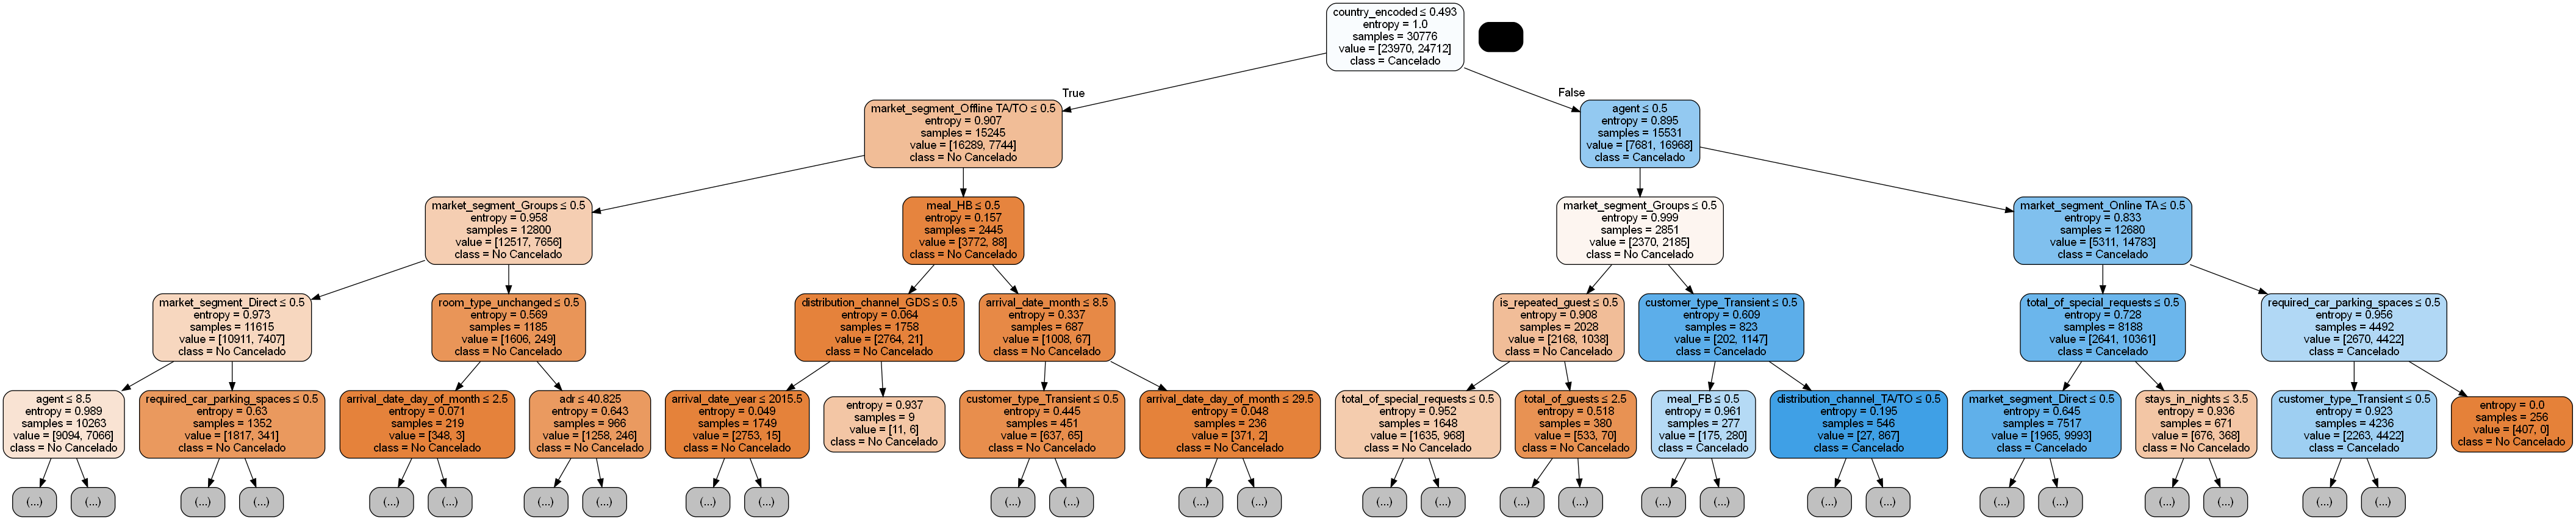

In [10]:
dot_data = StringIO()
export_graphviz(model_rf.estimators_[1], out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features,
                class_names=['No Cancelado','Cancelado'],
                max_depth=4)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

---

## Análisis del modelo Random Forest

#### Reporte de clasificación y matriz de confusión:

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      6033
           1       0.87      0.87      0.87      6138

    accuracy                           0.87     12171
   macro avg       0.87      0.87      0.87     12171
weighted avg       0.87      0.87      0.87     12171



Text(50.722222222222214, 0.5, 'True')

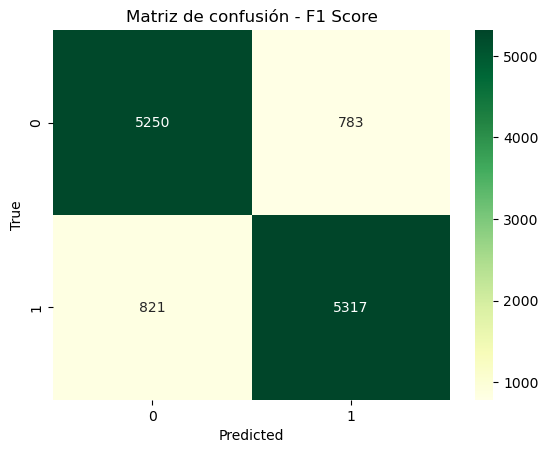

In [11]:
# Hacemos predicción sobre el set de evaluacion
y_pred = model_rf.predict(x_test)

# Reporte y Matriz de Confusion
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGn',annot=True,fmt='g')
plt.title("Matriz de confusión - F1 Score")
plt.xlabel('Predicted')
plt.ylabel('True')

Score de cada split:

In [12]:
results = cross_validate(model_rf, x_train, y_train, cv=kfoldcv,scoring=scorer_fn,return_estimator=True)

metricsCV = results['test_score']
metricsCV

array([0.87419355, 0.87127509, 0.8679781 , 0.87370348, 0.87347437,
       0.87545345, 0.86968839, 0.86355293, 0.87146689, 0.86229508])

#### Score de accuracy:

In [13]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc*100))

Accuracy: 86.82%


#### Gráfico del boxplot de F1 Score:

<Axes: >

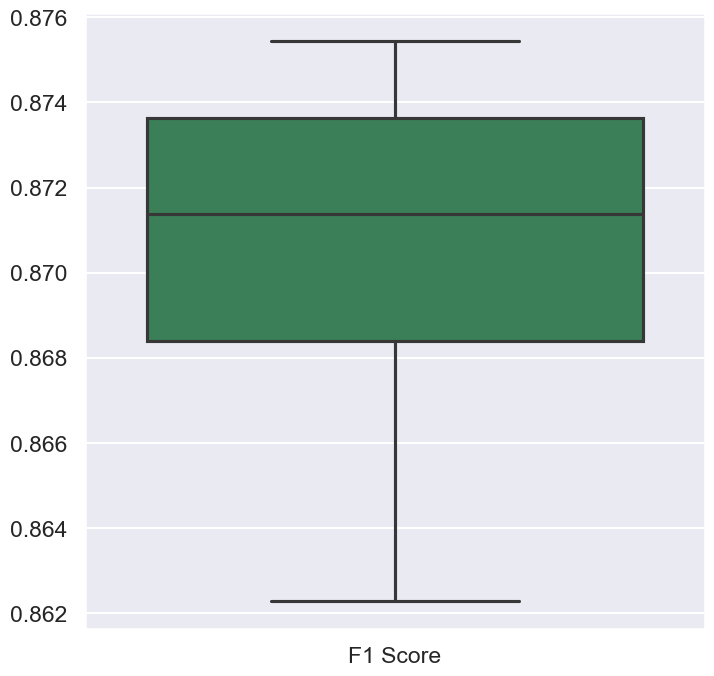

In [14]:
metric_labelsCV = ['F1 Score']*len(metricsCV)
sns.set_context('talk')
sns.set_style("darkgrid")
plt.figure(figsize=(8,8))
sns.boxplot(x=metric_labelsCV, y=metricsCV, color='seagreen')

#### Gráfico de curva ROC:

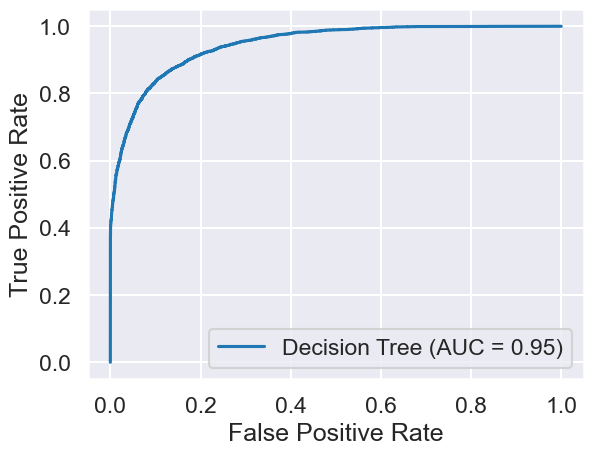

In [15]:
y_pred = model_rf.predict_proba(x_test)[:, 1]  # obtener las probabilidades para la clase positiva
fpr, tpr, _ = roc_curve(y_test, y_pred) # FPR y TPR son acrónimos de "False Positive Rate" y "True Positive Rate"
roc_auc = roc_auc_score(y_test, y_pred)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Decision Tree').plot()
plt.legend(loc="lower right")  # agregar leyenda en la esquina inferior derecha
plt.show()

---

## Aplicación del modelo al dataset de test

##### Lectura del dataset de test preprocesado:

In [16]:
hotel_test = pd.read_csv('./dataset/hotels_test_preprocesado.csv')

##### Lectura del dataset de test original para mantener id:

In [17]:
hotel_test_df = pd.read_csv('./dataset/hotels_test.csv')

##### Predicción y exportación:

In [18]:

x_test_final = hotel_test[features]

y_pred_final = model_rf.predict(x_test_final)


In [19]:
pd.concat([hotel_test_df['id'],pd.DataFrame(data=y_pred_final, columns=['is_canceled'])], axis=1).to_csv('./predicciones/pred_randomforest_n10_split10.csv', index=False)

---

## Exportación del modelo

In [20]:
dump(model_rf, open('./modelos/model_randomforest_randomcv.pkl', 'wb'))

---